In [1]:
import pandas as pd
import sys
import os
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.stats import zscore
from pydeseq2.default_inference import DefaultInference
from scipy.stats import norm


sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv
from src.utils.Preprocessing import classify_cancer_type, elimnation_zeros, initialize_DeseqDataSet
from src.utils.plots import (box_plot, histogram_log2,
                             PCA_variables_log2, 
                             PCA_2_variables,
                             PCA_4_scatter_matrix_log2)
%matplotlib inline


In [2]:
df_clincal_data = pd.read_csv("../../data/raw/brca_tcga_pub2015_clinical_data.tsv", sep='\t')
print(len(df_clincal_data.index))

print(f"Number of rows: {df_clincal_data.shape[0]} and number of columns: {df_clincal_data.shape[1]}")

818
Number of rows: 818 and number of columns: 110


In [3]:
df_clincal_data["Disease Free (Months)"]
df_clincal_data["Disease Free Status"]

0      0:DiseaseFree
1      0:DiseaseFree
2      0:DiseaseFree
3      0:DiseaseFree
4      0:DiseaseFree
           ...      
813    0:DiseaseFree
814    0:DiseaseFree
815    0:DiseaseFree
816    0:DiseaseFree
817              NaN
Name: Disease Free Status, Length: 818, dtype: object

In [4]:
df_clincal_data["Overall Survival (Months)"].unique()
df_clincal_data["Overall Survival Status"].unique()


array(['0:LIVING', '1:DECEASED'], dtype=object)

In [5]:
df_clincal_data["ER Status By IHC"].head(20)

0     Positive
1     Positive
2     Positive
3     Positive
4     Negative
5     Positive
6     Positive
7     Negative
8     Positive
9     Positive
10    Negative
11    Positive
12    Positive
13    Negative
14    Negative
15    Positive
16    Negative
17    Negative
18    Positive
19    Negative
Name: ER Status By IHC, dtype: object

In [6]:
df_clincal_data["PR status by ihc"].head(10)

0    Negative
1    Positive
2    Positive
3    Positive
4    Positive
5    Positive
6    Positive
7    Negative
8    Negative
9    Positive
Name: PR status by ihc, dtype: object

In [7]:
df_clincal_data["HER2 ihc score"].dropna().head(20)

2     1.0
4     2.0
6     2.0
7     0.0
8     3.0
10    0.0
14    2.0
15    2.0
16    2.0
17    1.0
18    2.0
20    3.0
21    1.0
23    1.0
24    0.0
27    2.0
29    2.0
30    2.0
31    2.0
32    1.0
Name: HER2 ihc score, dtype: float64

In [8]:
print(df_clincal_data["HER2 fish status"].isna().sum() / len(df_clincal_data))
print(df_clincal_data["HER2 ihc score"].isna().sum() / len(df_clincal_data))


0.6149144254278729
0.4315403422982885


In [9]:
df_clincal_data["HER2 ihc score"].unique()
df_clincal_data.columns.unique()

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'American Joint Committee on Cancer Tumor Stage Code',
       'Brachytherapy first reference point administered total dose',
       ...
       'Somatic Status', 'Staging System', 'Staging System.1',
       'Surgery for positive margins', 'Surgery for positive margins other',
       'Surgical procedure first', 'Tissue Source Site', 'TMB (nonsynonymous)',
       'Person Neoplasm Status', 'Tumor Disease Anatomic Site'],
      dtype='object', length=110)

In [10]:
list_df = classify_cancer_type(df_clinical_data=df_clincal_data)

luminal_A = [x for x in list_df if x == "Luminal A"]
luminal_B = [x for x in list_df if x == "Luminal B"]
HER2_enriched = [x for x in list_df if x == "HER2-enriched"]
TNBC = [x for x in list_df if x == "TNBC"]
UNK = [x for x in list_df if x == "<UNK>"]

print(f"Luminal A: {len(luminal_A)} - Total(%): {len(luminal_A) / len(df_clincal_data):.2f}")
print(f"Luminal B: {len(luminal_B)} - Total(%):{len(luminal_B) / len(df_clincal_data):.2f}")
print(f"HER2-enriched: {len(HER2_enriched)} - Total(%):{len(HER2_enriched) / len(df_clincal_data):.2f}")
print(f"TNBC: {len(TNBC)} - Total(%){len(TNBC) / len(df_clincal_data):.2f} ")
print(f"UNK: {len(UNK)} - Total(%) {len(UNK) / len(df_clincal_data):.2f}")

df_clincal_data["Tumor-Cancer"] = list_df



Luminal A: 330 - Total(%): 0.40
Luminal B: 81 - Total(%):0.10
HER2-enriched: 23 - Total(%):0.03
TNBC: 85 - Total(%)0.10 
UNK: 299 - Total(%) 0.37


In [11]:
df_clincal_data["Tumor-Cancer"].unique()

array(['<UNK>', 'Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'],
      dtype=object)

In [12]:
#Luminal A 
luminal_a_dataset = df_clincal_data[df_clincal_data["Tumor-Cancer"] == "Luminal A"]

#Luminal B
luminal_b_dataset = df_clincal_data[df_clincal_data["Tumor-Cancer"] == "Luminal B"]

In [13]:
df_mRNA = pd.read_csv("../../data/raw/data_mrna_seq_v2_rsem.txt", header=None)

In [14]:
df_mRNA_transformed = TextToCsv("../../data/raw/data_mrna_seq_v2_rsem.txt")

Shape of the CSV: (20440, 819)


Clincal Data Set

In [15]:
df_clincal_data["Tumor-Cancer"].unique()

array(['<UNK>', 'Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'],
      dtype=object)

mRNA seq

In [16]:
df_mRNA_transformed = df_mRNA_transformed.drop(columns=["Hugo_Symbol", "Entrez_Gene_Id"], axis=0)


In [17]:
df_mrna = df_mRNA_transformed.T.reset_index()

In [18]:
df_mRNA_final = df_mrna.rename(columns={"index":"Sample ID"})
df_mRNA_final

,Sample ID,0,1,2,3,4,5,6,7,8,...,20430,20431,20432,20433,20434,20435,20436,20437,20438,20439
0,TCGA-A1-A0SB-01,14.3935,116.3870,279.7612,0.4505,0.0,0.9010,0.9010,1.8020,0.0000,...,95.9568,519.4279,1415.9252,19.3716,1364.5681,6186.7327,1931.2986,1436.1978,552.3144,0.0000
1,TCGA-A1-A0SD-01,11.3241,60.2630,83.6986,0.3308,0.0,0.6616,0.3308,4.6315,0.3308,...,96.2700,578.2814,1225.7051,33.0825,868.0837,3559.6725,1278.9678,1195.6000,86.0144,0.0000
2,TCGA-A1-A0SE-01,4.4426,153.1452,74.7018,0.0000,0.0,0.0000,0.9872,5.5944,0.3291,...,95.4340,726.6146,1018.8400,57.5895,960.5923,3007.8157,926.3677,1075.4422,866.1456,0.0000
3,TCGA-A1-A0SF-01,10.7401,141.1933,314.4482,0.0000,0.0,0.0000,2.9988,9.4249,0.0000,...,74.1138,533.3625,1053.4444,94.6772,881.2262,5343.4779,934.3482,508.0867,52.2652,0.8568
4,TCGA-A1-A0SH-01,3.0048,79.8003,95.7054,0.0000,0.0,0.0000,0.3612,3.9727,0.0000,...,87.7601,581.0946,801.3977,19.8634,1353.2389,5464.9614,1312.7898,1001.1151,455.7746,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,TCGA-MS-A51U-01,7.9343,150.6834,540.4278,1.5649,0.0,0.5216,0.0000,6.2598,0.0000,...,79.2906,443.9228,1083.4637,40.6886,858.1116,4930.6208,2212.8326,665.6234,249.8696,0.0000
813,TCGA-OL-A66H-01,2.2519,115.3378,338.1985,2.0851,0.0,0.0000,2.0851,4.1701,0.0000,...,45.4545,747.7064,903.6697,10.4254,634.2786,4163.4696,1251.8766,773.1443,5.8382,0.0000
814,TCGA-OL-A66I-01,1.2603,158.3599,210.7460,0.4173,0.0,2.0866,2.5039,2.5039,0.4173,...,61.3459,334.2723,933.1247,206.1555,479.0819,6621.1789,649.3479,780.3860,47.1570,0.0000
815,TCGA-OL-A66J-01,5.0428,124.6327,323.1185,0.4507,0.0,0.0000,8.1118,5.8585,3.1546,...,45.5160,797.6566,1038.3055,13.9703,683.1906,5216.7643,1408.7427,713.3844,567.3727,0.0000


In [19]:
df_merged = pd.merge(df_mRNA_final, df_clincal_data, right_on="Sample ID", left_on="Sample ID")
df_merged[df_merged["Tumor-Cancer"] == "HER2-enriched"]

,Sample ID,0,1,2,3,4,5,6,7,8,...,Staging System,Staging System.1,Surgery for positive margins,Surgery for positive margins other,Surgical procedure first,Tissue Source Site,TMB (nonsynonymous),Person Neoplasm Status,Tumor Disease Anatomic Site,Tumor-Cancer
17,TCGA-A2-A04U-01,0.5195,411.4041,78.9713,0.0000,0.0000,0.0000,6.7541,4.1564,0.0000,...,Sentinel node biopsy alone,NaN,NaN,NaN,Simple Mastectomy,A2,1.600000,TUMOR FREE,Breast,HER2-enriched
19,TCGA-A2-A04W-01,4.6360,101.3265,137.7820,0.0000,0.0000,0.5403,6.4839,4.3226,0.0000,...,Axillary lymph node dissection alone,NaN,NaN,NaN,Modified Radical Mastectomy,A2,3.400000,TUMOR FREE,Breast,HER2-enriched
58,TCGA-A2-A0T1-01,4.3184,175.3956,208.6170,0.7491,0.0000,1.8727,0.7491,5.9926,0.0000,...,Axillary lymph node dissection alone,NaN,NaN,NaN,Lumpectomy,A2,0.500000,TUMOR FREE,Breast,HER2-enriched
80,TCGA-A2-A1G1-01,5.4402,154.6038,55.2539,0.5498,0.0000,0.0000,0.2749,4.1234,0.0000,...,Sentinel lymph node biopsy plus axillary disse...,NaN,NaN,NaN,Lumpectomy,A2,0.933333,TUMOR FREE,Breast,HER2-enriched
99,TCGA-A2-A3XZ-01,20.0965,165.1206,474.8449,0.0000,0.0000,1.0338,2.0675,5.1688,0.0000,...,Sentinel node biopsy alone,NaN,NaN,NaN,Simple Mastectomy,A2,1.233333,TUMOR FREE,Breast,HER2-enriched
182,TCGA-A8-A08X-01,2.1620,183.6392,108.7014,0.0000,0.0000,0.0000,9.0084,5.4050,0.0000,...,NaN,NaN,NaN,NaN,Other,A8,0.600000,TUMOR FREE,Breast,HER2-enriched
210,TCGA-A8-A0A7-01,3.7220,121.4684,170.0039,0.0000,1.1779,12.5638,0.3926,4.3188,0.0000,...,NaN,NaN,NaN,NaN,Other,A8,3.966667,TUMOR FREE,Breast,HER2-enriched
257,TCGA-AN-A0FV-01,3.7600,174.1104,67.9789,0.0000,0.0000,77.9645,3.0725,4.9928,14.5943,...,No axillary staging,NaN,NaN,NaN,Modified Radical Mastectomy,AN,2.166667,TUMOR FREE,Breast,HER2-enriched
415,TCGA-BH-A0EE-01,2.3665,117.1883,177.4059,0.0000,0.0000,0.0000,0.6695,9.0377,0.0000,...,Sentinel node biopsy alone,NaN,NaN,NaN,Simple Mastectomy,BH,2.633333,TUMOR FREE,Breast,HER2-enriched
497,TCGA-C8-A12P-01,4.3752,80.5846,96.6756,0.3821,0.0000,0.0000,0.0000,4.9675,2.2927,...,NaN,NaN,NaN,NaN,Other,C8,4.100000,TUMOR FREE,Breast,HER2-enriched


In [20]:
comparation_df = df_merged.loc[
    df_merged["Tumor-Cancer"].isin(["Luminal A", "Luminal B", "TNBC", "HER2-enriched"]),
    ["Tumor-Cancer"] + list(df_merged.columns[1:20441])
]



comparation_df["Tumor-Cancer"].unique()

array(['Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'], dtype=object)

In [21]:
print(comparation_df.shape[0])
print(comparation_df.shape[1])

zeros_reduced_df = elimnation_zeros(comparation_df)
print(zeros_reduced_df.shape[0])

519
20441
Max of zeros per row in the dataset: 519
Avg of zeros per row in the dataset: 74.00381604696673
Median of zeros per row in the dataset: 0.0
Min of zeros per row in the dataset: 0
After the 0 elimination: 16270
519


In [22]:
zeros_reduced_df["Tumor-Cancer"].unique()

array(['Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'], dtype=object)

In [23]:
zeros_reduced_df.iloc[:,1:] = zeros_reduced_df.iloc[:, 1:].astype(int)


In [24]:
zeros_reduced_df

,Tumor-Cancer,0,1,2,7,14,17,18,19,22,...,20429,20430,20431,20432,20433,20434,20435,20436,20437,20438
2,Luminal A,4.0,153.0,74.0,5.0,299.0,476.0,100.0,192.0,70.0,...,810.0,95.0,726.0,1018.0,57.0,960.0,3007.0,926.0,1075.0,866.0
6,Luminal A,4.0,134.0,63.0,4.0,636.0,391.0,4.0,226.0,130.0,...,420.0,83.0,2731.0,834.0,51.0,1092.0,3032.0,958.0,718.0,43.0
7,TNBC,28.0,1119.0,166.0,3.0,68.0,330.0,7.0,86.0,404.0,...,1695.0,69.0,610.0,1775.0,158.0,1380.0,591.0,1798.0,1335.0,49.0
8,Luminal B,7.0,119.0,80.0,5.0,183.0,496.0,26.0,307.0,102.0,...,505.0,60.0,546.0,1014.0,39.0,1410.0,4570.0,1182.0,1454.0,1169.0
10,TNBC,9.0,190.0,140.0,5.0,69.0,328.0,7.0,36.0,64.0,...,1306.0,26.0,292.0,1040.0,241.0,681.0,3473.0,721.0,1414.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,Luminal A,7.0,150.0,540.0,6.0,217.0,622.0,63.0,362.0,144.0,...,294.0,79.0,443.0,1083.0,40.0,858.0,4930.0,2212.0,665.0,249.0
813,Luminal A,2.0,115.0,338.0,4.0,402.0,943.0,18.0,51.0,160.0,...,536.0,45.0,747.0,903.0,10.0,634.0,4163.0,1251.0,773.0,5.0
814,TNBC,1.0,158.0,210.0,2.0,244.0,501.0,5.0,207.0,87.0,...,482.0,61.0,334.0,933.0,206.0,479.0,6621.0,649.0,780.0,47.0
815,Luminal A,5.0,124.0,323.0,5.0,1139.0,543.0,22.0,267.0,39.0,...,465.0,45.0,797.0,1038.0,13.0,683.0,5216.0,1408.0,713.0,567.0


In [25]:
print(f"Genes: {zeros_reduced_df.shape[0]}, Samples: {zeros_reduced_df.shape[1]}")



Genes: 519, Samples: 16270


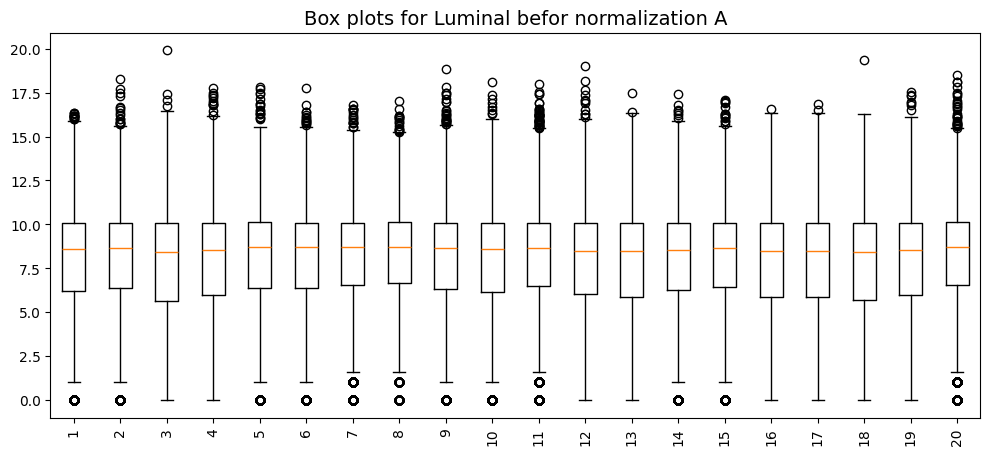

In [26]:
box_plot(df=zeros_reduced_df, title="Box plots for Luminal befor normalization A", type_cancer="Luminal A")

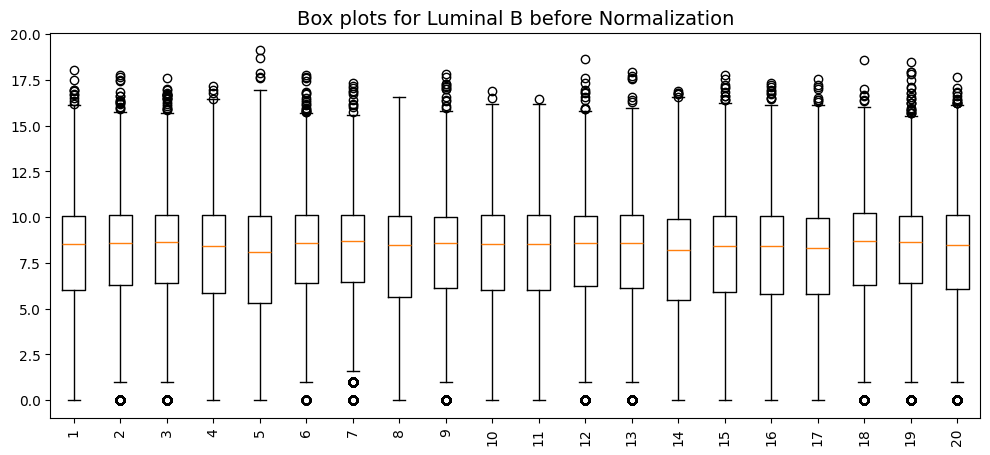

In [27]:
box_plot(df=zeros_reduced_df, title="Box plots for Luminal B before Normalization", type_cancer="Luminal B")

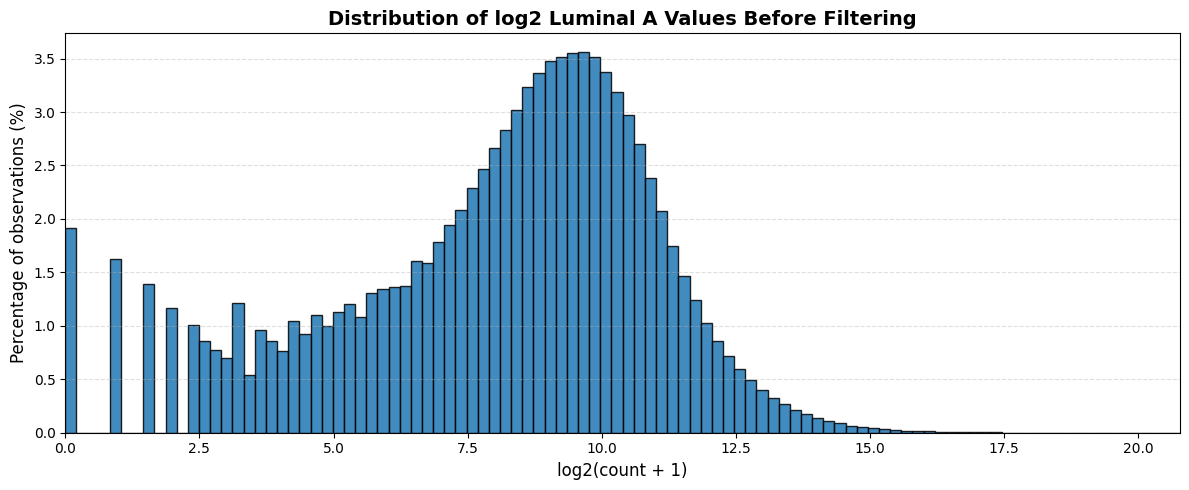

In [28]:
histogram_log2(df=zeros_reduced_df, title="Luminal A", type_cancer="Luminal A")

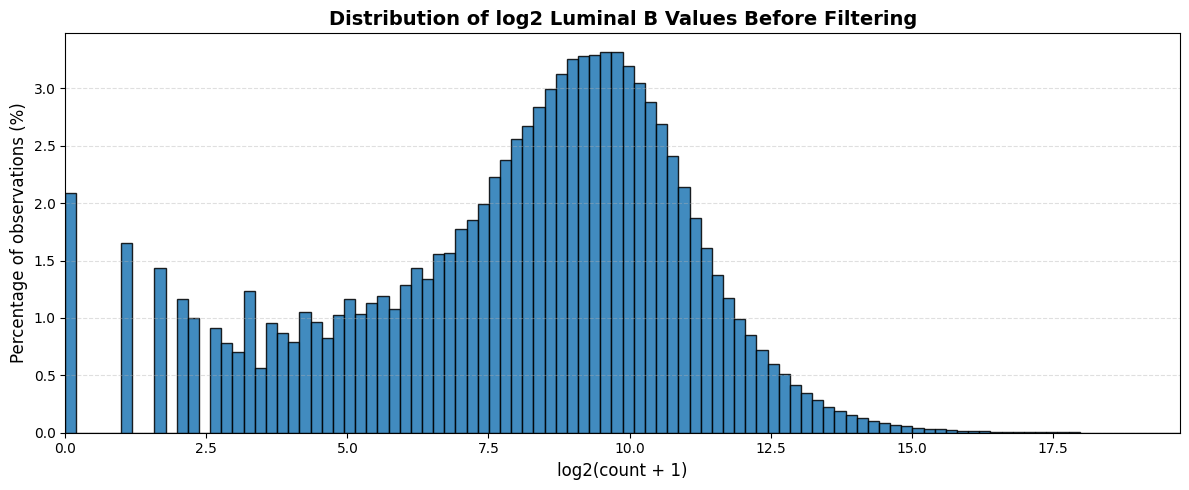

In [29]:
histogram_log2(df=zeros_reduced_df, title="Luminal B", type_cancer="Luminal B")

In [30]:

PCA_2_variables(df=zeros_reduced_df, cancer_type_one="Luminal A", cancer_type_two="Luminal B")


Split for making the Conditions for Deseq

In [31]:
PCA_variables_log2(df=zeros_reduced_df, cancer_types=["Luminal A", "Luminal B", "TNBC", "HER2-enriched"])

In [33]:
PCA_4_scatter_matrix_log2(df=zeros_reduced_df, cancer_types=["Luminal A", "Luminal B", "TNBC", "HER2-enriched"])

Initialization variables to enter into DeseqDataSet

In [33]:
metadata = pd.DataFrame(zeros_reduced_df["Tumor-Cancer"], index=zeros_reduced_df.index)
metadata.columns = ["Tumor_Cancer"]
counts_data = zeros_reduced_df.drop(columns=["Tumor-Cancer"])

metadata["Tumor_Cancer"]

2      Luminal A
6      Luminal A
7           TNBC
8      Luminal B
10          TNBC
         ...    
812    Luminal A
813    Luminal A
814         TNBC
815    Luminal A
816    Luminal A
Name: Tumor_Cancer, Length: 519, dtype: object

In [34]:
deseqDataSet_variable = initialize_DeseqDataSet(counts_data=counts_data,
                                                metadata=metadata,
                                                design="Tumor_Cancer")
deseqDataSet_variable.deseq2()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/functools.py:909: ImplicitModificationWarning:

Transforming to str index.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/functools.py:909: ImplicitModificationWarning:

Transforming to str index.

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.38 seconds.

Fitting dispersions...
... done in 20.32 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 21.89 seconds.

Fitting LFCs...
... done in 9.50 seconds.

Calculating cook's distance...
... done in 0.72 seconds.

Replacing 786 outlier genes.

Fitting dispersions...
... done in 1.02 seconds.

Fitting MAP dispersions...
... done in 1.04 seconds.

Fitting LFCs...
... done in 0.69 seconds.



In [35]:
print(deseqDataSet_variable.obs["Tumor_Cancer"].unique())

['Luminal A' 'TNBC' 'Luminal B' 'HER2-enriched']


In [37]:
mask_luminal_a = (metadata["Tumor_Cancer"] == "Luminal A")
mask_luminal_b = (metadata["Tumor_Cancer"] == "Luminal B")
mask_luminal_TNBC = (metadata["Tumor_Cancer"] == "TNBC")
mask_luminal_HER2 = (metadata["Tumor_Cancer"] == "HER2-enriched")

Mask_tumer = (metadata["Tumor_Cancer"])

In [38]:
norm_counts = deseqDataSet_variable.layers["normed_counts"]
normal_counts_luminal_A = norm_counts[mask_luminal_a]
normal_counts_luminal_B = norm_counts[mask_luminal_b]
normal_counts_luminal_TNBC = norm_counts[mask_luminal_TNBC]
normal_counts_luminal_HER2 = norm_counts[mask_luminal_HER2]

Box Plots After Normalization

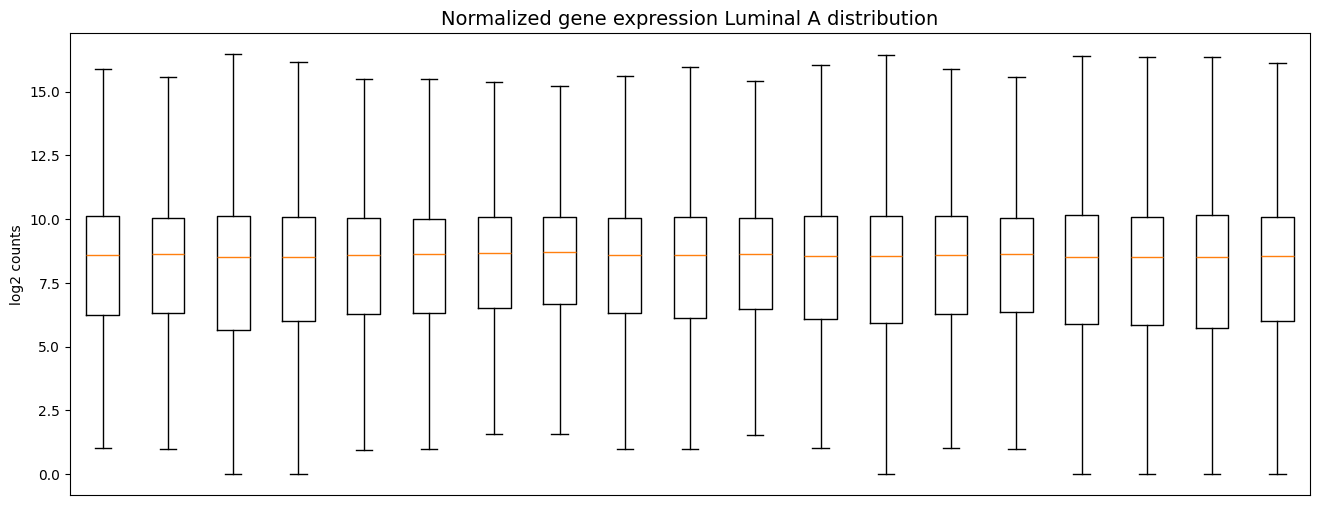

In [39]:
plt.figure(figsize=(16,6))
plt.boxplot(np.log2(normal_counts_luminal_A[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression Luminal A distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()

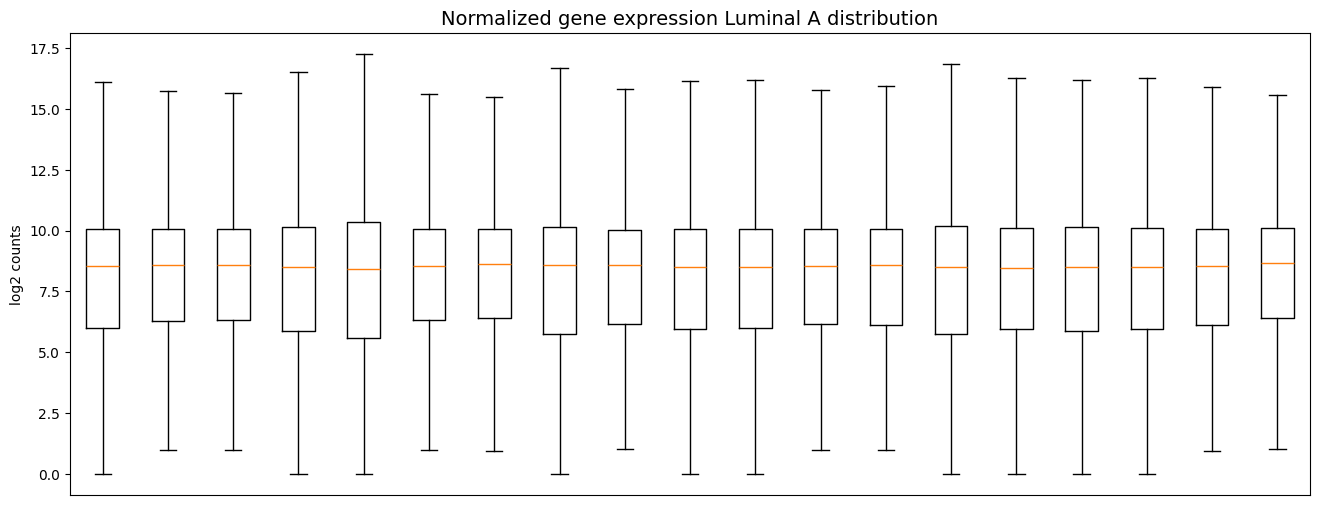

In [40]:
plt.figure(figsize=(16,6))
plt.boxplot(np.log2(normal_counts_luminal_B[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression Luminal A distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()

Histograms after the initialization

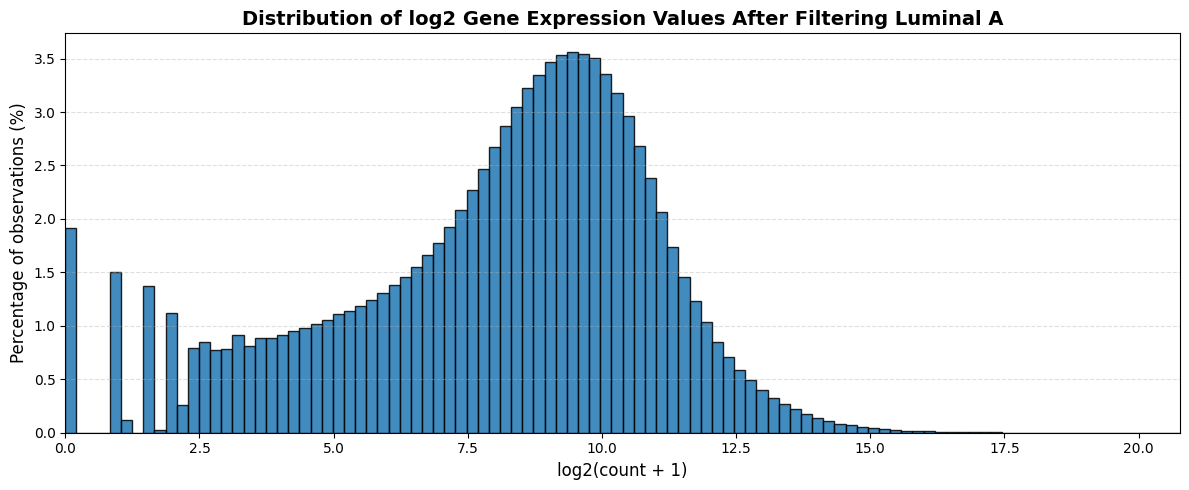

In [41]:
x = np.log2(normal_counts_luminal_A.ravel() + 1) # type: ignore
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values After Filtering Luminal A",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

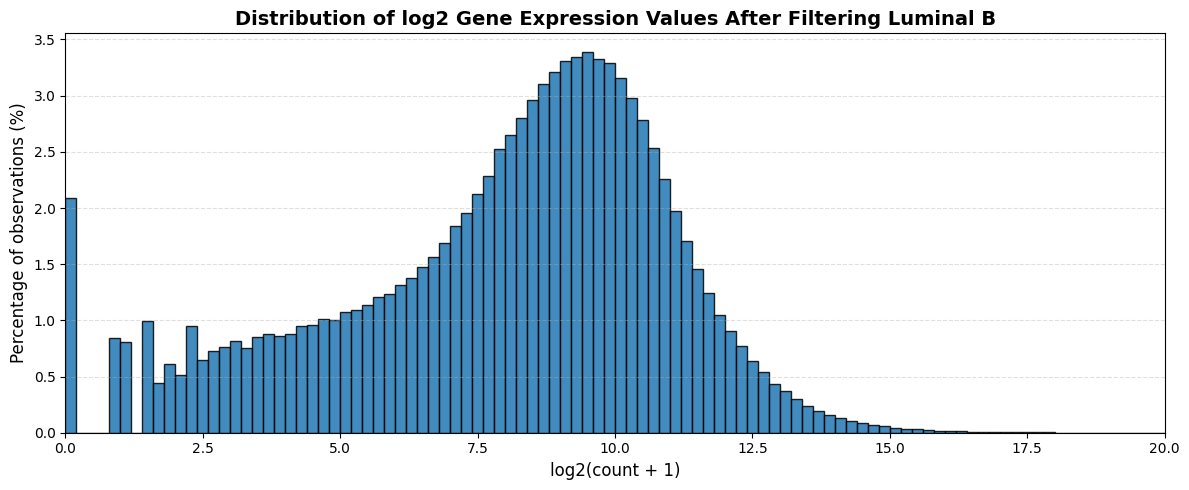

In [42]:
x = np.log2(normal_counts_luminal_B.ravel() + 1) # type: ignore
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values After Filtering Luminal B",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

In [43]:
norm_counts[mask_luminal_b]

array([[   7.09390933,  120.59645869,   81.07324954, ..., 1197.85726192,
        1473.50631035, 1184.68285887],
       [   1.96158995,   68.65564811,   44.13577378, ...,  990.60292272,
         703.22999563, 1679.12099375],
       [  13.71952586,  137.19525862,  345.92804494, ..., 1354.31319579,
         552.700899  ,  152.87471675],
       ...,
       [   0.        ,  119.86012777,  154.27541198, ...,  436.71808931,
         178.01009075,   35.60201815],
       [   1.97437719,   98.71885958,  362.29821466, ...,  951.64980636,
         501.49180667,   16.78220613],
       [   5.7990481 ,  199.1006515 ,   99.55032575, ..., 1115.35025158,
         477.45496038,   70.55508524]], shape=(81, 16269))

In [51]:
mask_a = np.asarray(mask_luminal_a)   # (n_samples,)
mask_b = np.asarray(mask_luminal_b) # (n_samples,)
mask_c = np.asarray(mask_luminal_TNBC)
mask_d = np.asarray(mask_luminal_HER2)

Xa = norm_counts[mask_a, :]  # Luminal A
Xb = norm_counts[mask_b, :]  # Luminal B
Xc = norm_counts[mask_c, :]  # TNBC
Xd = norm_counts[mask_d, :]  # HER2


X = np.vstack([Xa, Xb, Xc, Xd])
y = np.array(["Luminal A"] * Xa.shape[0] + ["Luminal B"] * Xb.shape[0] + ["TNBC"] * Xc.shape[0] + ["HER2-enriched"] * Xd.shape[0])


X_log = np.log2(X + 1)
X_scaled = StandardScaler().fit_transform(X_log)


pca = PCA(n_components=4, random_state=0)
components = pca.fit_transform(X_scaled)


df_plot = pd.DataFrame(components, columns=["PC1", "PC2", "PC3", "PC4"])
df_plot["Subtype"] = y

labels = {
        "PC1": f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
        "PC2": f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
        "PC3": f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)",
        "PC4": f"PC4 ({pca.explained_variance_ratio_[3]*100:.1f}%)",
    }


fig = px.scatter_matrix(
        df_plot,
        dimensions=["PC1", "PC2", "PC3", "PC4"],
        labels=labels,
        color="Subtype",
        title=f"PCA de Subtypes of cancer of mama with Log2 Luminal A, Luminal B,TNBC,HER2-enriched",
        opacity=0.7,
        color_discrete_map={"Luminal A": "#1f77b4",
                            "Luminal B": "#ec3204",
                            "TNBC": "#49fa09",
                            "HER2-enriched": "#fa09fa"},
)
fig.show()

In [52]:
inference = DefaultInference(n_cpus=2)
deseq_stats_test = DeseqStats(deseqDataSet_variable, contrast=["Tumor_Cancer", "Luminal A", "Luminal B","TNBC", "HER2-enriched"], inference=inference)

Running Wald tests...
... done in 9.11 seconds.



Log2 fold change & Wald test p-value: Tumor_Cancer Luminal A vs Luminal B
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0         6.615494       -0.132827  0.128724 -1.031875  0.302131  0.563708
1       118.652339       -0.013122  0.073407 -0.178762  0.858124  1.000000
2       213.092762        0.222426  0.113944  1.952070  0.050930  0.169916
7         5.650794        0.085728  0.100618  0.000000  1.000000  1.000000
14      413.575937       -0.026989  0.146982 -0.183618  0.854313  1.000000
...            ...             ...       ...       ...       ...       ...
20434   926.767624        0.031231  0.055613  0.561586  0.574398  0.826298
20435  3767.307800       -0.099277  0.077766 -1.276608  0.201741  0.435930
20436  1273.688628        0.171655  0.067790  2.532149  0.011337  0.057376
20437   982.078337        0.158323  0.070625  1.063038  0.287765  0.546602
20438   194.694506       -0.189725  0.229647 -0.826162  0.408712  0.677122

[16269 rows x 6 columns]


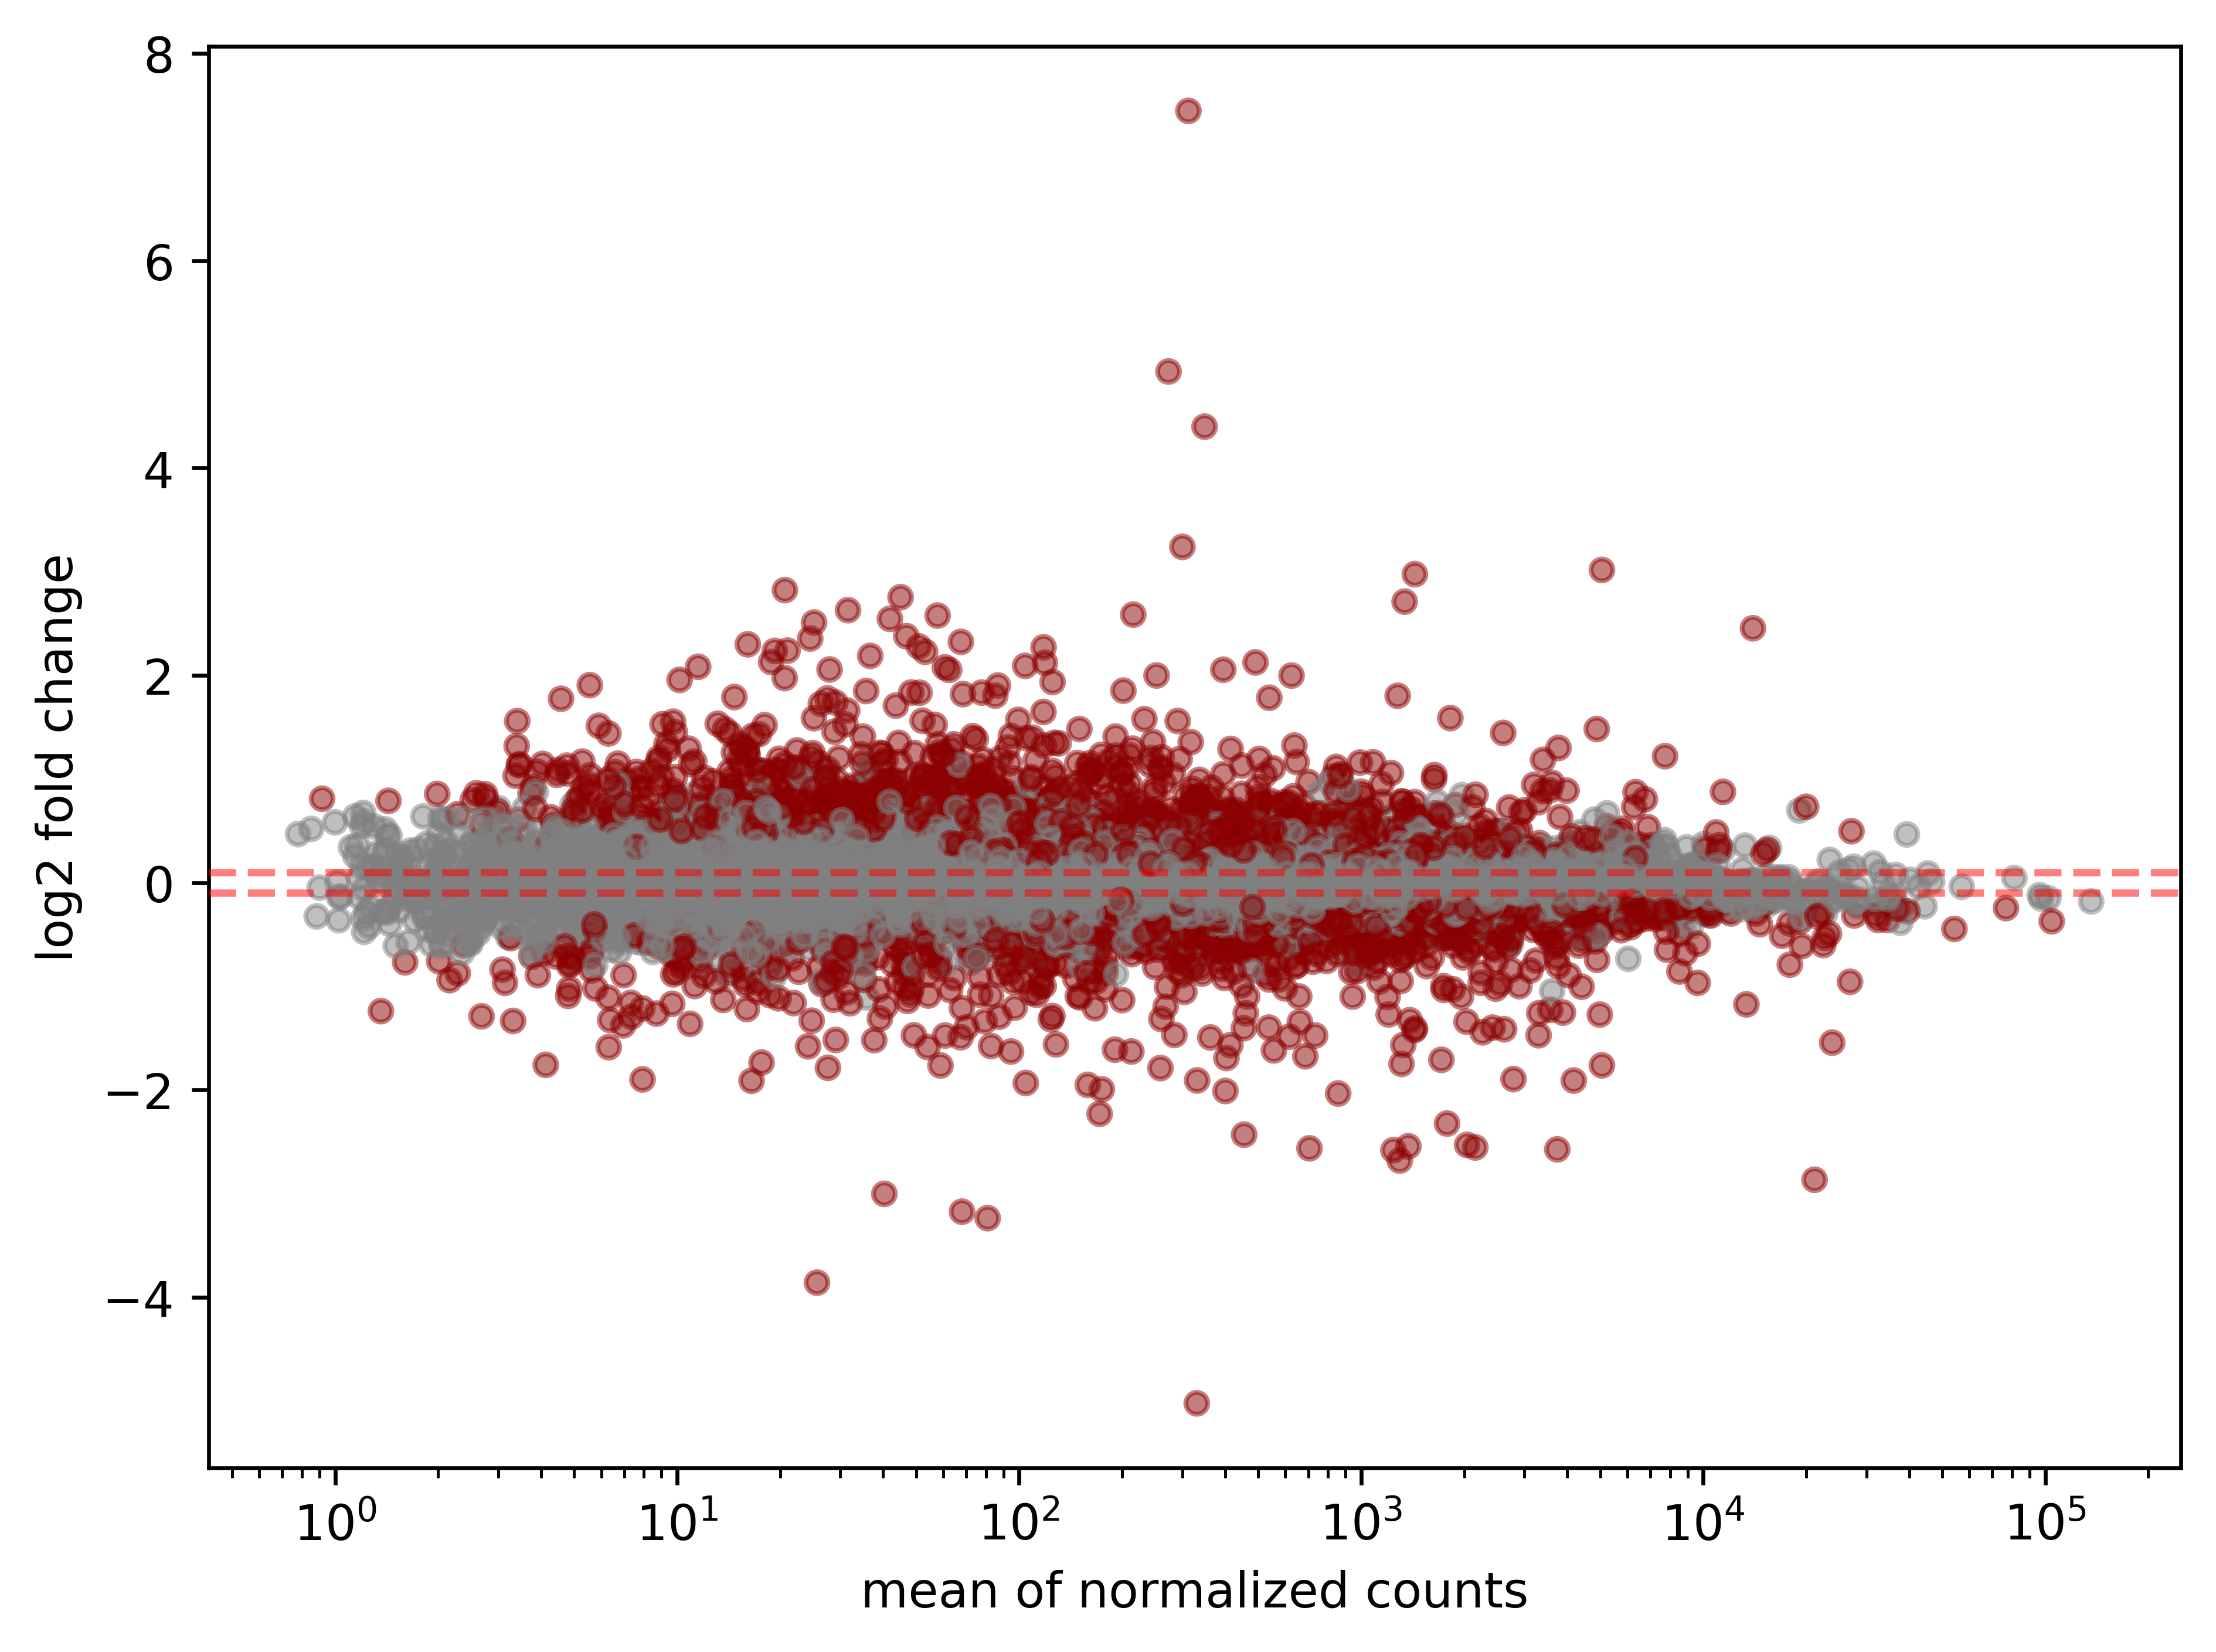

In [53]:
deseq_stats_test.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
deseq_stats_test.plot_MA(s=20)

In [55]:
print(type(deseqDataSet_variable))
deseqDataSet_variable_df = pd.DataFrame(deseqDataSet_variable.layers["normed_counts"])
print(type(deseqDataSet_variable_df))



<class 'pydeseq2.dds.DeseqDataSet'>
<class 'pandas.core.frame.DataFrame'>


In [56]:
deseqDataSet_variable_df

,0,1,2,3,4,5,6,7,8,9,...,16259,16260,16261,16262,16263,16264,16265,16266,16267,16268
0,3.894432,148.962010,72.046985,4.868040,291.108765,463.437364,97.360791,186.932718,68.152554,0.000000,...,788.622406,92.492751,706.839342,991.132851,55.495651,934.663592,2927.638981,901.560923,1046.628502,843.144449
1,4.033554,135.124060,63.528476,4.033554,641.335093,394.279908,4.033554,227.895803,131.090506,0.000000,...,423.523174,83.696246,2753.909022,840.996018,51.427814,1101.160253,3057.433963,966.036193,724.022950,43.360706
2,28.411420,1135.442112,168.439134,3.044081,68.999163,334.848880,7.102855,87.263648,409.936205,24.352646,...,1719.905611,70.013857,618.963081,1801.081098,160.321585,1400.277135,599.683903,1824.419050,1354.615924,49.719985
3,7.093909,120.596459,81.073250,5.067078,185.455058,502.654147,26.348806,311.118595,103.368393,0.000000,...,511.774888,60.804937,553.324928,1027.603438,39.523209,1428.916023,4631.309380,1197.857262,1473.506310,1184.682859
4,8.721900,184.129009,135.674006,4.845500,66.867903,317.864815,6.783700,34.887602,62.022403,826.642338,...,1265.644659,25.196601,282.977213,1007.864047,233.553111,659.957131,3365.684456,698.721132,1370.307463,14.536501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,6.835228,146.469177,527.289039,5.858767,211.892077,607.358856,61.517055,353.478948,140.610410,0.976461,...,287.079588,77.140433,432.572304,1057.507461,39.058447,837.803695,4813.953632,2159.932137,649.346687,243.138835
515,1.993579,114.630786,336.914832,3.987158,400.709356,939.972445,17.942210,50.836262,159.486311,0.000000,...,534.279141,44.855525,744.601714,900.100867,9.967894,631.964507,4149.634452,1246.983593,770.518239,4.983947
516,0.969509,153.182457,203.596937,1.939018,236.560250,485.724120,4.847546,200.688409,84.347302,792.089035,...,467.303445,59.140063,323.816080,904.552104,199.718900,464.394917,6419.120560,629.211485,756.217193,45.566933
517,4.915252,121.898249,317.525278,4.915252,1119.694400,533.796365,21.627109,262.474456,38.338965,1.966101,...,457.118434,44.237268,783.491165,1020.406310,12.779655,671.423420,5127.590863,1384.134957,700.914932,557.389574


In [57]:
z_counts = deseqDataSet_variable_df.apply(zscore, axis=1) # type: ignore
print(z_counts)

        0         1         2         3         4         5         6      \
0   -0.287923 -0.250719 -0.270445 -0.287673 -0.214265 -0.170070 -0.263953   
1   -0.335205 -0.298892 -0.318725 -0.335205 -0.158667 -0.227104 -0.335205   
2   -0.281486 -0.011418 -0.247325 -0.287674 -0.271584 -0.206728 -0.286684   
3   -0.210250 -0.192274 -0.198533 -0.210571 -0.182002 -0.131764 -0.207200   
4   -0.286953 -0.244028 -0.255886 -0.287902 -0.272724 -0.211301 -0.287428   
..        ...       ...       ...       ...       ...       ...       ...   
514 -0.253825 -0.222175 -0.135860 -0.254046 -0.207347 -0.117711 -0.241431   
515 -0.155633 -0.140137 -0.109556 -0.155359 -0.100779 -0.026589 -0.153439   
516 -0.292276 -0.253048 -0.240055 -0.292026 -0.231559 -0.167344 -0.291277   
517 -0.332653 -0.297135 -0.237740 -0.332653  0.005809 -0.172078 -0.327579   
518 -0.283805 -0.256936 -0.138921 -0.284332 -0.001677 -0.053044 -0.240867   

        7         8         9      ...     16259     16260     16261  \
0  

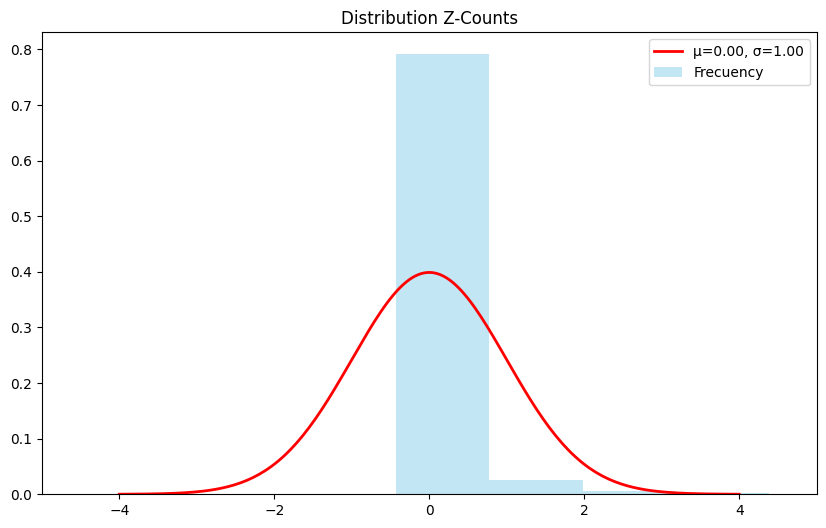

In [58]:
data = z_counts.values.ravel()


mu = np.nanmean(data) 
std = np.nanstd(data)

counts, bins = np.histogram(data, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1]-bins[0]), color='skyblue', alpha=0.5, label='Frecuency')

x = np.linspace(mu - 4*std, mu + 4*std, 200)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', lw=2, label=f'μ={mu:.2f}, σ={std:.2f}')

plt.title("Distribution Z-Counts")
plt.xlim(-5, 5)
plt.legend()
plt.show()

In [59]:
upper_outliers = np.sum(data > 3)
down_outliers = np.sum(data < -3)
total = len(data)
print(f"total of data: {total}")
print(f"Outliers Upper (>3): {upper_outliers} ({100*upper_outliers/total:.4f}%)")
print(f"Outliers Down (<-3): {down_outliers} ({100*down_outliers/total:.4f}%)")

total of data: 8443611
Outliers Upper (>3): 74294 (0.8799%)
Outliers Down (<-3): 0 (0.0000%)
